# MLP

In [1]:
from typing import Literal
from numpy import array, ndarray
from matplotlib.pyplot import subplots, figure, savefig, show
from sklearn.neural_network import MLPClassifier
from dslab_functions import (
    CLASS_EVAL_METRICS,
    DELTA_IMPROVE,
    read_train_test_from_files,
)
from dslab_functions import HEIGHT, plot_evaluation_results, plot_multiline_chart


def mlp_study(
    trnX: ndarray,
    trnY: array,
    tstX: ndarray,
    tstY: array,
    nr_max_iterations: int = 2500,
    lag: int = 500,
    metric: str = "accuracy",
) -> tuple[MLPClassifier | None, dict]:
    nr_iterations: list[int] = [lag] + [
        i for i in range(2 * lag, nr_max_iterations + 1, lag)
    ]

    lr_types: list[Literal["constant", "invscaling", "adaptive"]] = [
        "constant",
        "invscaling",
        "adaptive",
    ]  # only used if optimizer='sgd'
    learning_rates: list[float] = [0.5, 0.05, 0.005, 0.0005]

    best_model: MLPClassifier | None = None
    best_params: dict = {"name": "MLP", "metric": metric, "params": ()}
    best_performance: float = 0.0

    values: dict = {}
    _, axs = subplots(
        1, len(lr_types), figsize=(len(lr_types) * HEIGHT, HEIGHT), squeeze=False
    )
    for i in range(len(lr_types)):
        type: str = lr_types[i]
        values = {}
        for lr in learning_rates:
            warm_start: bool = False
            y_tst_values: list[float] = []
            for j in range(len(nr_iterations)):
                clf = MLPClassifier(
                    learning_rate=type,
                    learning_rate_init=lr,
                    max_iter=lag,
                    warm_start=warm_start,
                    activation="logistic",
                    solver="sgd",
                    verbose=False,
                )
                clf.fit(trnX, trnY)
                prdY: array = clf.predict(tstX)
                eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
                y_tst_values.append(eval)
                warm_start = True
                if eval - best_performance > DELTA_IMPROVE:
                    best_performance = eval
                    best_params["params"] = (type, lr, nr_iterations[j])
                    best_model = clf
                # print(f'MLP lr_type={type} lr={lr} n={nr_iterations[j]}')
            values[lr] = y_tst_values
        plot_multiline_chart(
            nr_iterations,
            values,
            ax=axs[0, i],
            title=f"MLP with {type}",
            xlabel="nr iterations",
            ylabel=metric,
            percentage=True,
        )
    print(
        f'MLP best for {best_params["params"][2]} iterations (lr_type={best_params["params"][0]} and lr={best_params["params"][1]}'
    )

    return best_model, best_params

In [2]:
from pandas import read_csv, DataFrame
from sklearn.model_selection import train_test_split

train_filename = "data/class_pos_covid/data_preparation/balancing/smote.csv"
test_filename = "data/class_pos_covid/data_preparation/balancing/balancing_test.csv"
file_tag = "class_pos_covid"
#data : DataFrame = read_csv(filename)
target = 'CovidPos'

'''
labels = data[target].unique()
X, y = data.loc[:, data.columns != 'CovidPos'], data['CovidPos']
trnX, tstX, trnY, tstY = train_test_split(X, y, test_size = 0.33, random_state=1)
'''

trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(
    train_filename, test_filename, target
)

eval_metric = "recall"

print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")

Train#=356572 Test#=124045
Labels=[0, 1]


### PARAMETERS STUDY

MLP best for 750 iterations (lr_type=constant and lr=0.5


<Figure size 600x450 with 0 Axes>

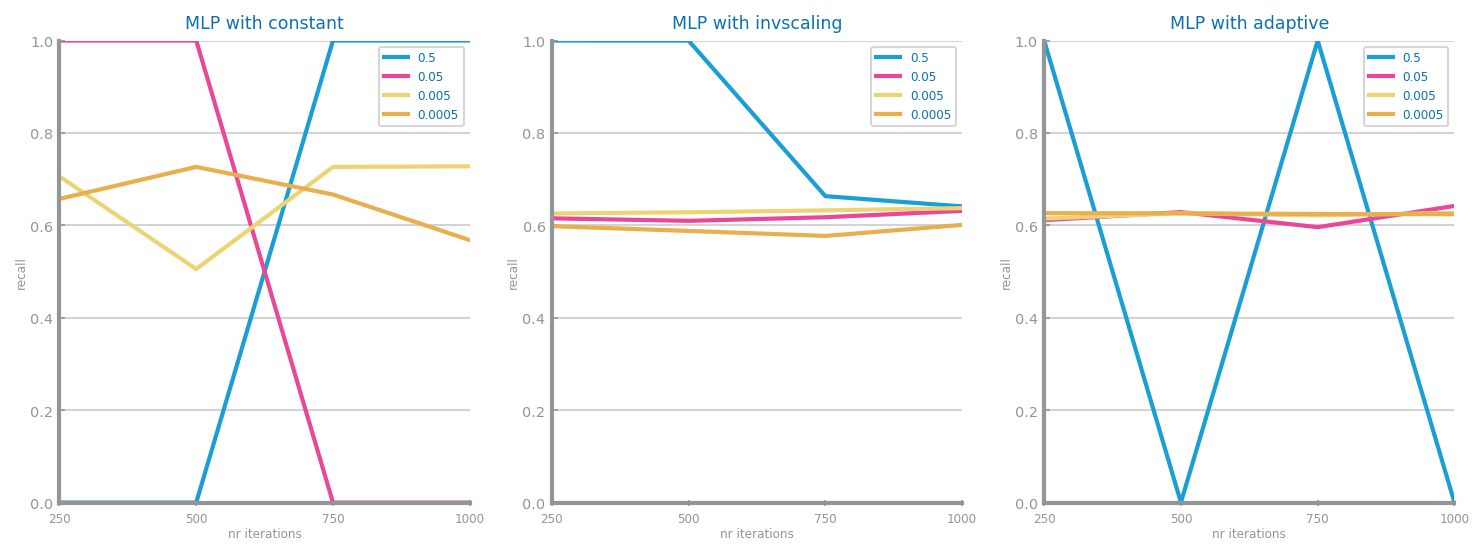

In [3]:
figure()
best_model, params = mlp_study(
    trnX,
    trnY,
    tstX,
    tstY,
    nr_max_iterations=1000,
    lag=250,
    metric=eval_metric,
)
savefig(f"images/{file_tag}/data_classification/mlp/{eval_metric}_study.png")
show()

### BEST MODEL PERFORMANCE

<Figure size 600x450 with 0 Axes>

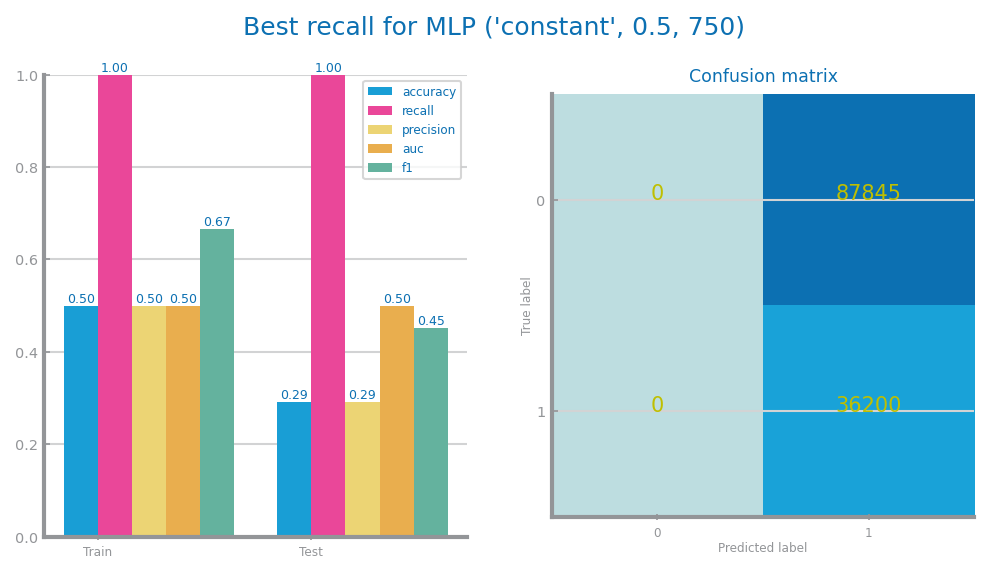

In [4]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f"images/{file_tag}/data_classification/mlp/{params['name']}_best_{params['metric']}_eval.png")
show()

### OVERFITTING STUDY

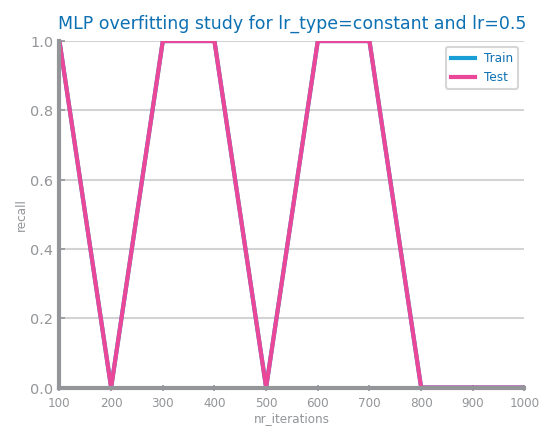

In [5]:
lr_type: Literal["constant", "invscaling", "adaptive"] = params["params"][0]
lr: float = params["params"][1]
nr_iterations: list[int] = [i for i in range(100, 1001, 100)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric = "recall"

warm_start: bool = False
for n in nr_iterations:
    clf = MLPClassifier(
        warm_start=warm_start,
        learning_rate=lr_type,
        learning_rate_init=lr,
        max_iter=n,
        activation="logistic",
        solver="sgd",
        verbose=False,
    )
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))
    warm_start = True

figure()
plot_multiline_chart(
    nr_iterations,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"MLP overfitting study for lr_type={lr_type} and lr={lr}",
    xlabel="nr_iterations",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}/data_classification/mlp/{eval_metric}_overfitting.png")

# SVM (not needed in forms)

In [6]:
from sklearn.svm import SVC

def svm_study(
    trnX: ndarray,
    trnY: array,
    tstX: ndarray,
    tstY: array,
    nr_max_iterations: int = 2500,
    lag: int = 500,
    metric: str = "accuracy",
) -> tuple[SVC | None, dict]:
    nr_iterations: list[int] = [100] + [
        i for i in range(500, nr_max_iterations + 1, lag)
    ]

    kernel_types: list[str] = ["linear", "poly", "rbf", "sigmoid"]
    poly_degrees: list[int] = [2, 3, 4]

    best_model = None
    best_params: dict = {"name": "SVM", "metric": metric, "params": ()}
    best_performance: float = 0.0

    values: dict = {}
    for kernel in kernel_types:
        degrees: list[int] = poly_degrees if "poly" == kernel else [0]
        for d in degrees:
            kernel_name: str = f"poly_{d}" if "poly" == kernel else kernel
            y_tst_values: list[float] = []
            for n in nr_iterations:
                clf = SVC(kernel=kernel, max_iter=n, degree=d, verbose=False)
                clf.fit(trnX, trnY)
                prdY: array = clf.predict(tstX)
                eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
                y_tst_values.append(eval)
                if eval - best_performance > DELTA_IMPROVE:
                    best_performance = eval
                    best_params["params"] = (kernel, n, d)
                    best_model = clf
                # print(f'SVM lr_type={kernel_name} n={n} -> {eval}')
            values[kernel_name] = y_tst_values
    plot_multiline_chart(
        nr_iterations,
        values,
        title=f"SVM models ({metric})",
        xlabel="nr iterations",
        ylabel=metric,
        percentage=True,
    )
    best_kernel = best_params["params"][0]
    kernel_name = (
        f'poly_{best_params["params"][2]}' if "poly" == best_kernel else best_kernel
    )
    print(f'SVM best for {kernel_name} and n={best_params["params"][1]}')

    return best_model, best_params

In [7]:
from pandas import read_csv, DataFrame
from sklearn.model_selection import train_test_split

train_filename = "data/class_pos_covid/data_preparation/balancing/smote.csv"
test_filename = "data/class_pos_covid/data_preparation/balancing/balancing_test.csv"
file_tag = "class_pos_covid"
#data : DataFrame = read_csv(filename)
target = 'CovidPos'

'''
labels = data[target].unique()
X, y = data.loc[:, data.columns != 'CovidPos'], data['CovidPos']
trnX, tstX, trnY, tstY = train_test_split(X, y, test_size = 0.33, random_state=1)
'''

trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(
    train_filename, test_filename, target
)

eval_metric = "recall"

print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")

'\nfilename = "data/class_pos_covid/data_preparation/balancing/oversampling.csv"\nfile_tag = "class_pos_covid"\ndata : DataFrame = read_csv(filename)\n\ntarget = \'CovidPos\'\nlabels = data[target].unique()\nX, y = data.loc[:, data.columns != \'CovidPos\'], data[\'CovidPos\']\ntrnX, tstX, trnY, tstY = train_test_split(X, y, test_size = 0.33, random_state=1)\n\neval_metric = "recall"\n\nprint(f"Train#={len(trnX)} Test#={len(tstX)}")\nprint(f"Labels={labels}")\n'

### PARAMETERS STUDY

SVM best for poly_4 and n=100


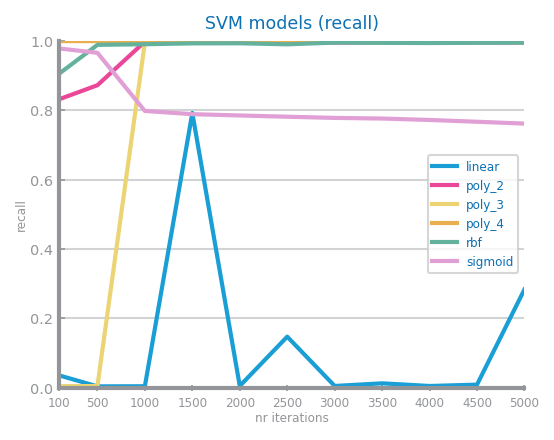

In [8]:
figure()
best_model, params = svm_study(
    trnX,
    trnY,
    tstX,
    tstY,
    nr_max_iterations=5000,
    lag=500,
    metric=eval_metric,
)
savefig(f"images/{file_tag}/data_classification/svm/{eval_metric}_study.png")
show()

### BEST MODEL PERFORMANCE

<Figure size 600x450 with 0 Axes>

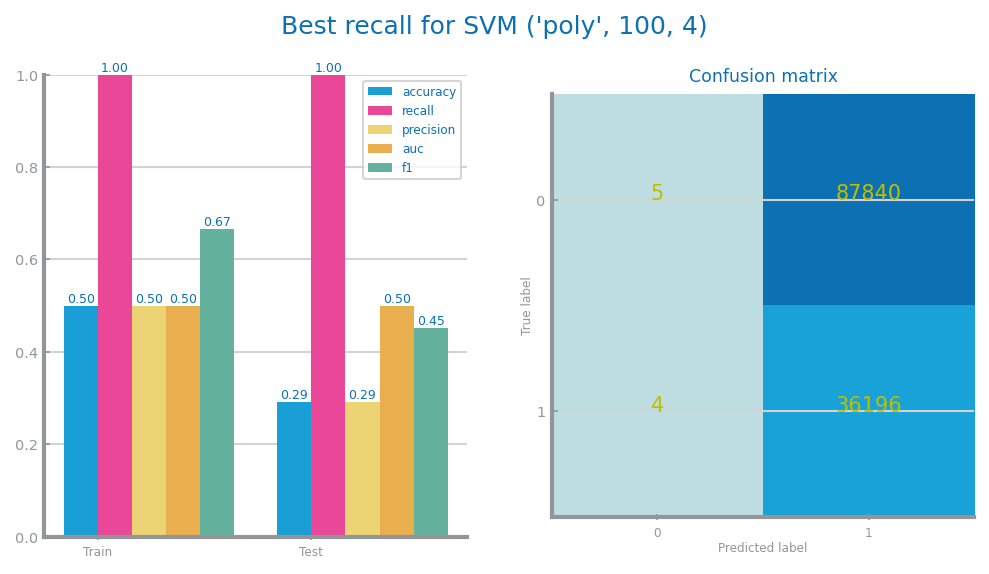

In [9]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f"images/{file_tag}/data_classification/svm/{params['name']}_best_{params['metric']}_eval.png")
show()

### OVERFITTING STUDY

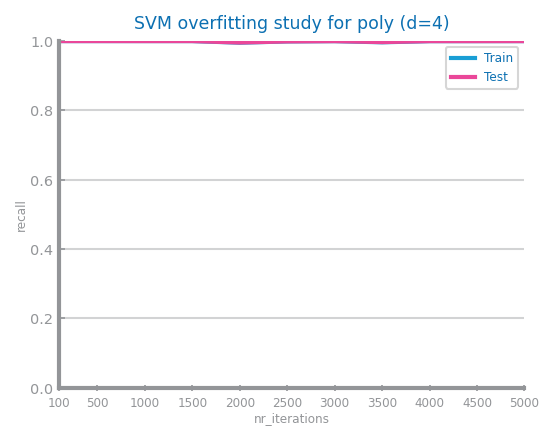

In [10]:
kernel: str = params["params"][0]
degree: int = params["params"][2]
kernel_name: str = f'poly (d={params["params"][2]})' if "poly" == kernel else kernel
nr_iterations: list[int] = [100] + [i for i in range(500, 5001, 500)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric: str = "recall"

warm_start: bool = False
for n in nr_iterations:
    clf = SVC(kernel=kernel, max_iter=n, degree=degree, verbose=False)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))
    warm_start = True

figure()
plot_multiline_chart(
    nr_iterations,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"SVM overfitting study for {kernel_name}",
    xlabel="nr_iterations",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}/data_classification/svm/{eval_metric}_overfitting.png")

# RANDOM FORESTS

In [11]:
from sklearn.ensemble import RandomForestClassifier

def random_forests_study(
    trnX: ndarray,
    trnY: array,
    tstX: ndarray,
    tstY: array,
    nr_max_trees: int = 2500,
    lag: int = 500,
    metric: str = "accuracy",
) -> tuple[RandomForestClassifier | None, dict]:
    n_estimators: list[int] = [100] + [i for i in range(500, nr_max_trees + 1, lag)]
    max_depths: list[int] = [2, 5, 7]
    max_features: list[float] = [0.1, 0.3, 0.5, 0.7, 0.9]

    best_model: RandomForestClassifier | None = None
    best_params: dict = {"name": "RF", "metric": metric, "params": ()}
    best_performance: float = 0.0

    values: dict = {}

    cols: int = len(max_depths)
    _, axs = subplots(1, cols, figsize=(cols * HEIGHT, HEIGHT), squeeze=False)
    for i in range(len(max_depths)):
        d: int = max_depths[i]
        values = {}
        for f in max_features:
            y_tst_values: list[float] = []
            for n in n_estimators:
                clf = RandomForestClassifier(
                    n_estimators=n, max_depth=d, max_features=f
                )
                clf.fit(trnX, trnY)
                prdY: array = clf.predict(tstX)
                eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
                y_tst_values.append(eval)
                if eval - best_performance > DELTA_IMPROVE:
                    best_performance = eval
                    best_params["params"] = (d, f, n)
                    best_model = clf
                # print(f'RF d={d} f={f} n={n}')
            values[f] = y_tst_values
        plot_multiline_chart(
            n_estimators,
            values,
            ax=axs[0, i],
            title=f"Random Forests with max_depth={d}",
            xlabel="nr estimators",
            ylabel=metric,
            percentage=True,
        )
    print(
        f'RF best for {best_params["params"][2]} trees (d={best_params["params"][0]} and f={best_params["params"][1]})'
    )
    return best_model, best_params

In [5]:
from pandas import read_csv, DataFrame
from sklearn.model_selection import train_test_split

train_filename = "data/class_pos_covid/data_preparation/balancing/smote.csv"
test_filename = "data/class_pos_covid/data_preparation/balancing/balancing_test.csv"
file_tag = "class_pos_covid"
#data : DataFrame = read_csv(filename)
target = 'CovidPos'

'''
labels = data[target].unique()
X, y = data.loc[:, data.columns != 'CovidPos'], data['CovidPos']
trnX, tstX, trnY, tstY = train_test_split(X, y, test_size = 0.33, random_state=1)
'''

trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(
    train_filename, test_filename, target
)

eval_metric = "recall"

print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")

Train#=356615 Test#=175647
Labels=[1 0]


### PARAMETERS STUDY

RF best for 100 trees (d=2 and f=0.5)


<Figure size 600x450 with 0 Axes>

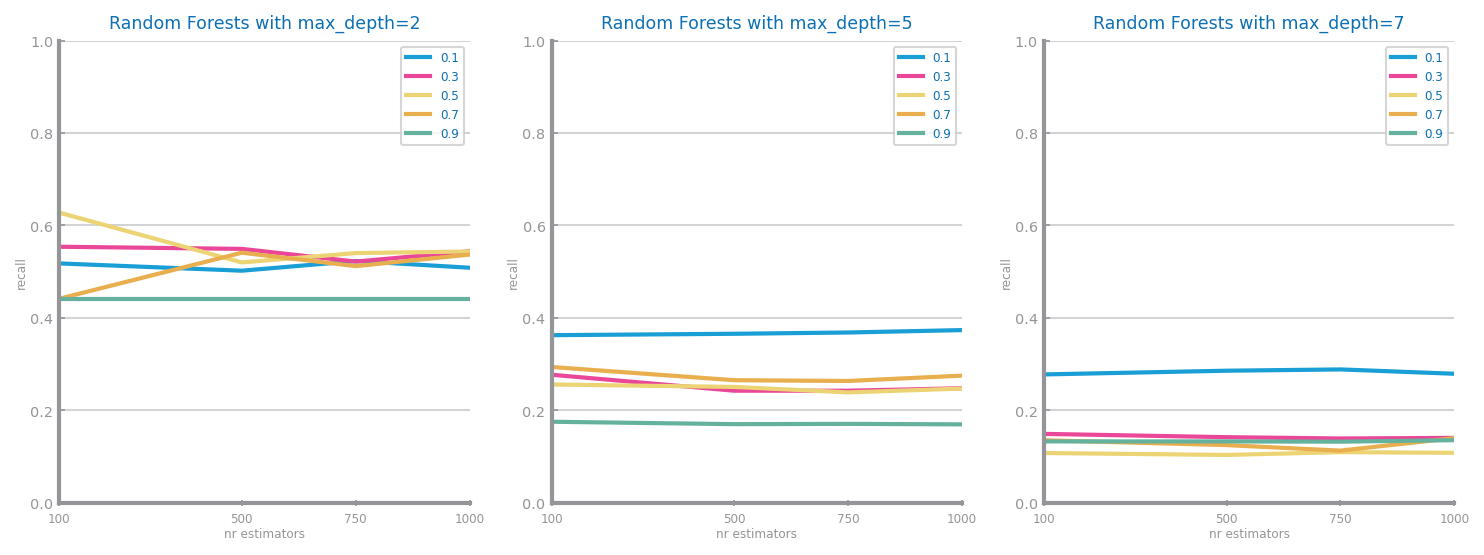

In [12]:
figure()
best_model, params = random_forests_study(
    trnX,
    trnY,
    tstX,
    tstY,
    nr_max_trees=1000,
    lag=250,
    metric=eval_metric,
)
savefig(f"images/{file_tag}/data_classification/random_forests/{eval_metric}_study.png")
show()

### BEST MODEL PERFORMANCE

<Figure size 600x450 with 0 Axes>

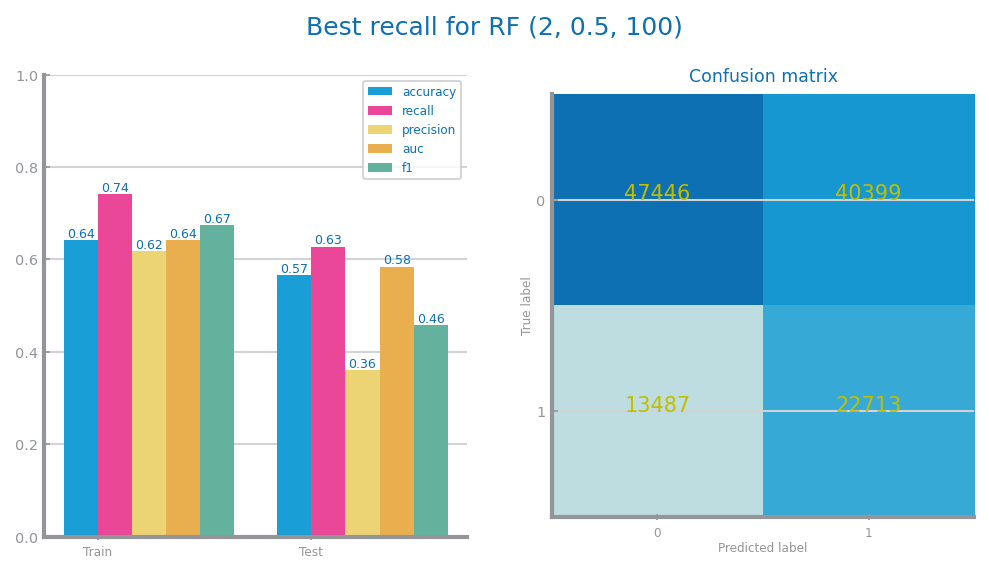

In [13]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f"images/{file_tag}/data_classification/random_forests/{params['name']}_best_{params['metric']}_eval.png")
show()

### VARIABLES IMPORTANCE

In [6]:
'''
vars = data.columns.tolist()
vars.remove("CovidPos")
print(vars)
'''

['MentalHealthDays', 'SleepHours', 'WeightInKilograms', 'BMI', 'State', 'GeneralHealth', 'LastCheckupTime', 'RemovedTeeth', 'HadDiabetes', 'SmokerStatus', 'ECigaretteUsage', 'RaceEthnicityCategory', 'AgeCategory', 'TetanusLast10Tdap', 'Sex', 'PhysicalActivities', 'HadHeartAttack', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands', 'ChestScan', 'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'HighRiskLastYear']


1. AgeCategory (0.4582012982179217)
2. FluVaxLast12 (0.18585739843508584)
3. HIVTesting (0.13988192228681723)
4. AlcoholDrinkers (0.09486925811940651)
5. ChestScan (0.047024994177239716)
6. PneumoVaxEver (0.04166504131454467)
7. RemovedTeeth (0.009218794647993)
8. TetanusLast10Tdap (0.007991396178595246)
9. HadArthritis (0.007155907182580985)
10. SleepHours (0.002925218044874738)
11. SmokerStatus (0.002729913243071863)
12. PhysicalActivities (0.0024788581518685087)
13. RaceEthnicityCategory (0.0)
14. ECigaretteUsage (0.0)
15. HighRiskLastYear (0.0)
16. HadDiabetes (0.0)
17. Sex (0.0)
18. GeneralHealth (0.0)
19. State (0.0)
20. BMI (0.0)
21. WeightInKilograms (0.0)
22. LastCheckupTime (0.0)
23. HadStroke (0.0)
24. HadHeartAttack (0.0)
25. HadAngina (0.0)
26. HadAsthma (0.0)
27. HadSkinCancer (0.0)
28. HadCOPD (0.0)
29. HadDepressiveDisorder (0.0)
30. HadKidneyDisease (0.0)
31. DeafOrHardOfHearing (0.0)
32. BlindOrVisionDifficulty (0.0)
33. DifficultyConcentrating (0.0)
34. DifficultyWal

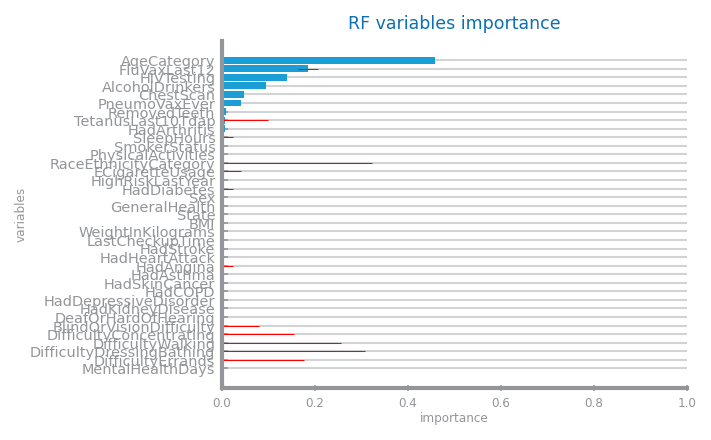

In [14]:
from numpy import std, argsort
from dslab_functions import plot_horizontal_bar_chart

stdevs: list[float] = list(
    std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)
)
importances = best_model.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values.append(importances[indices[f]])
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    error=stdevs,
    title="RF variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"images/{file_tag}/data_classification/random_forests/{eval_metric}_vars_ranking.png")

### OVERFITTING STUDY

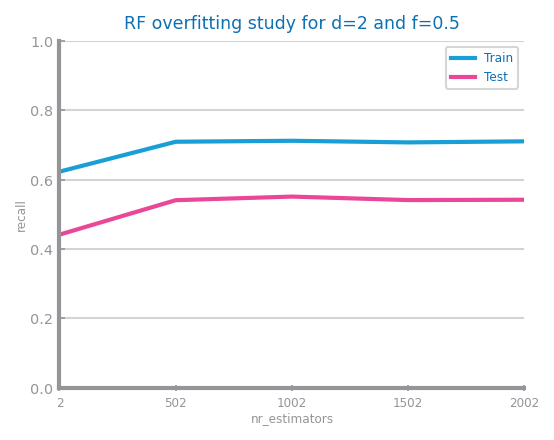

In [15]:
d_max: int = params["params"][0]
feat: float = params["params"][1]
nr_estimators: list[int] = [i for i in range(2, 2501, 500)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric: str = "recall"

for n in nr_estimators:
    clf = RandomForestClassifier(n_estimators=n, max_depth=d_max, max_features=feat)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    nr_estimators,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"RF overfitting study for d={d_max} and f={feat}",
    xlabel="nr_estimators",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}/data_classification/random_forests/{eval_metric}_overfitting.png")

# GRADIENT BOOSTING

In [16]:
from sklearn.ensemble import GradientBoostingClassifier

def gradient_boosting_study(
    trnX: ndarray,
    trnY: array,
    tstX: ndarray,
    tstY: array,
    nr_max_trees: int = 2500,
    lag: int = 500,
    metric: str = "accuracy",
) -> tuple[GradientBoostingClassifier | None, dict]:
    n_estimators: list[int] = [100] + [i for i in range(500, nr_max_trees + 1, lag)]
    max_depths: list[int] = [2, 5, 7]
    learning_rates: list[float] = [0.1, 0.3, 0.5, 0.7, 0.9]

    best_model: GradientBoostingClassifier | None = None
    best_params: dict = {"name": "GB", "metric": metric, "params": ()}
    best_performance: float = 0.0

    values: dict = {}
    cols: int = len(max_depths)
    _, axs = subplots(1, cols, figsize=(cols * HEIGHT, HEIGHT), squeeze=False)
    for i in range(len(max_depths)):
        d: int = max_depths[i]
        values = {}
        for lr in learning_rates:
            y_tst_values: list[float] = []
            for n in n_estimators:
                clf = GradientBoostingClassifier(
                    n_estimators=n, max_depth=d, learning_rate=lr
                )
                clf.fit(trnX, trnY)
                prdY: array = clf.predict(tstX)
                eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
                y_tst_values.append(eval)
                if eval - best_performance > DELTA_IMPROVE:
                    best_performance = eval
                    best_params["params"] = (d, lr, n)
                    best_model = clf
                # print(f'GB d={d} lr={lr} n={n}')
            values[lr] = y_tst_values
        plot_multiline_chart(
            n_estimators,
            values,
            ax=axs[0, i],
            title=f"Gradient Boosting with max_depth={d}",
            xlabel="nr estimators",
            ylabel=metric,
            percentage=True,
        )
    print(
        f'GB best for {best_params["params"][2]} trees (d={best_params["params"][0]} and lr={best_params["params"][1]}'
    )

    return best_model, best_params

In [8]:
from pandas import read_csv, DataFrame
from sklearn.model_selection import train_test_split

train_filename = "data/class_pos_covid/data_preparation/balancing/smote.csv"
test_filename = "data/class_pos_covid/data_preparation/balancing/balancing_test.csv"
file_tag = "class_pos_covid"
#data : DataFrame = read_csv(filename)
target = 'CovidPos'

'''
labels = data[target].unique()
X, y = data.loc[:, data.columns != 'CovidPos'], data['CovidPos']
trnX, tstX, trnY, tstY = train_test_split(X, y, test_size = 0.33, random_state=1)
'''

trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(
    train_filename, test_filename, target
)

eval_metric = "recall"

print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")

Train#=356615 Test#=175647
Labels=[1 0]


### PARAMETERS STUDY

GB best for 1000 trees (d=7 and lr=0.9


<Figure size 600x450 with 0 Axes>

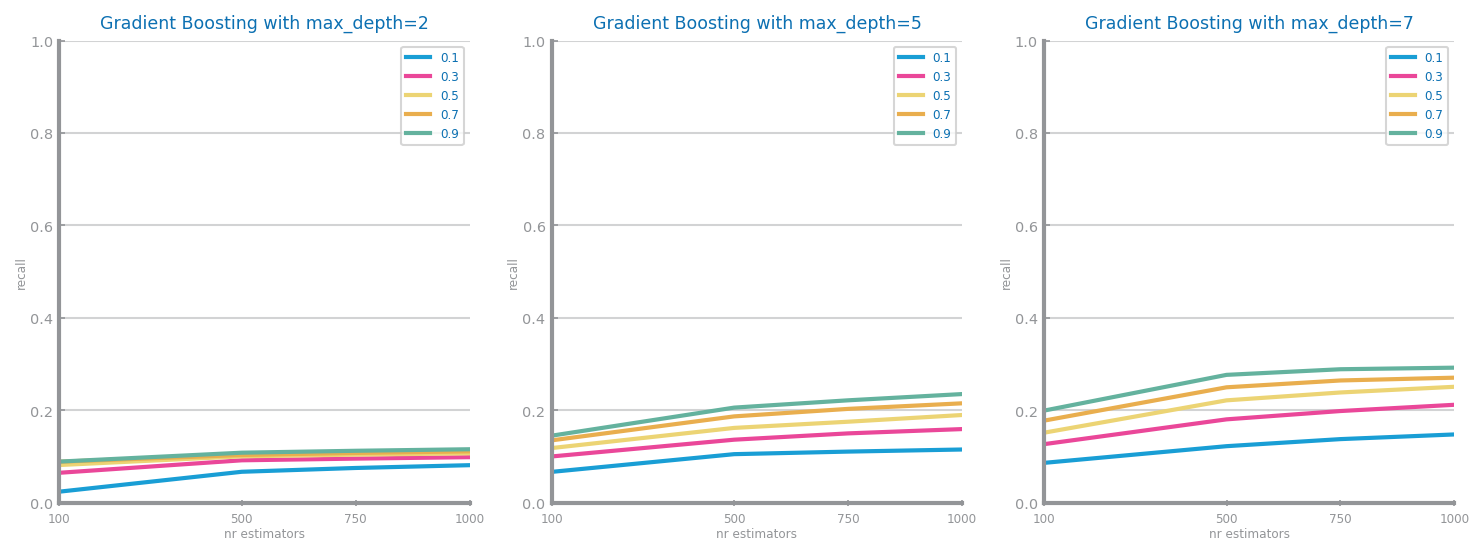

In [17]:
figure()
best_model, params = gradient_boosting_study(
    trnX,
    trnY,
    tstX,
    tstY,
    nr_max_trees=1000,
    lag=250,
    metric=eval_metric,
)
savefig(f"images/{file_tag}/data_classification/gradient_boosting/{eval_metric}_study.png")
show()

### BEST MODEL PERFORMANCE

<Figure size 600x450 with 0 Axes>

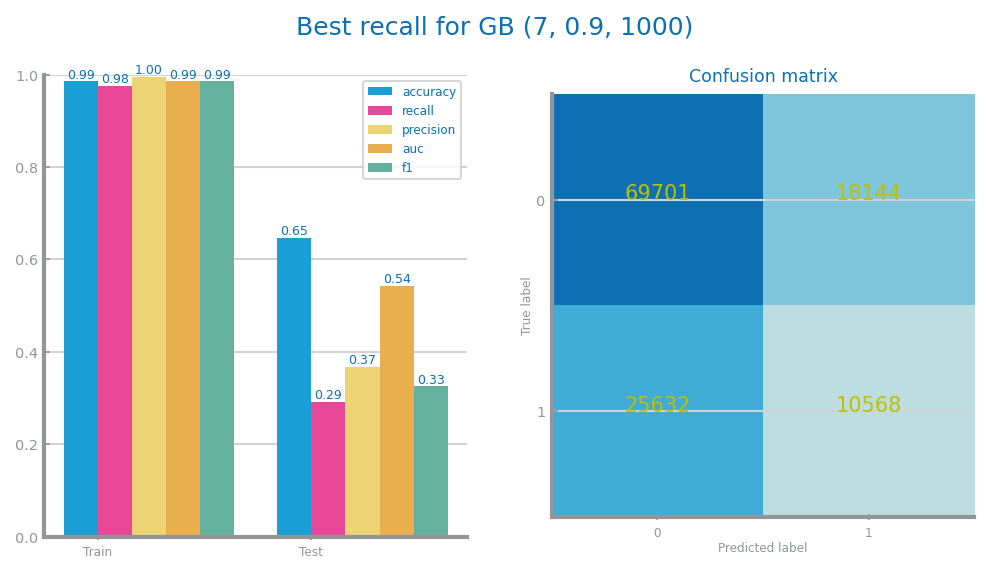

In [18]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f"images/{file_tag}/data_classification/gradient_boosting/{params['name']}_best_{params['metric']}_eval.png")
show()

### VARIABLES IMPORTANCE

1. AgeCategory (0.1600827710973878)
2. AlcoholDrinkers (0.12026988091659126)
3. ChestScan (0.11061816986597184)
4. BMI (0.07686412630830777)
5. FluVaxLast12 (0.07273826348676014)
6. HIVTesting (0.06617286228284949)
7. State (0.05272764900721672)
8. WeightInKilograms (0.044883362985390286)
9. TetanusLast10Tdap (0.035580557416316376)
10. SleepHours (0.029627582500735414)
11. HadArthritis (0.023532901457006886)
12. LastCheckupTime (0.021052820888852696)
13. MentalHealthDays (0.019874507059480274)
14. GeneralHealth (0.018830045483315107)
15. HadAsthma (0.017795091098993177)
16. SmokerStatus (0.01623177089094445)
17. Sex (0.014967891331158174)
18. RemovedTeeth (0.014637581675809933)
19. RaceEthnicityCategory (0.014542589911196183)
20. ECigaretteUsage (0.010300341037354969)
21. HadDiabetes (0.006024212292621144)
22. PneumoVaxEver (0.005509104802761579)
23. HadDepressiveDisorder (0.005007010416613551)
24. PhysicalActivities (0.004885448931142337)
25. HadSkinCancer (0.0040922659859774346)
26. 

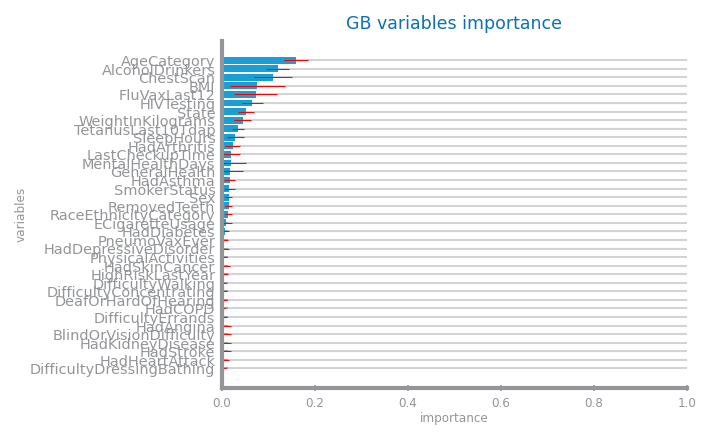

In [19]:
from numpy import std, argsort
from dslab_functions import plot_horizontal_bar_chart

trees_importances: list[float] = []
for lst_trees in best_model.estimators_:
    for tree in lst_trees:
        trees_importances.append(tree.feature_importances_)

stdevs: list[float] = list(std(trees_importances, axis=0))
importances = best_model.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values.append(importances[indices[f]])
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    error=stdevs,
    title="GB variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"images/{file_tag}/data_classification/gradient_boosting/{eval_metric}_vars_ranking.png")

### OVERFITTING STUDY

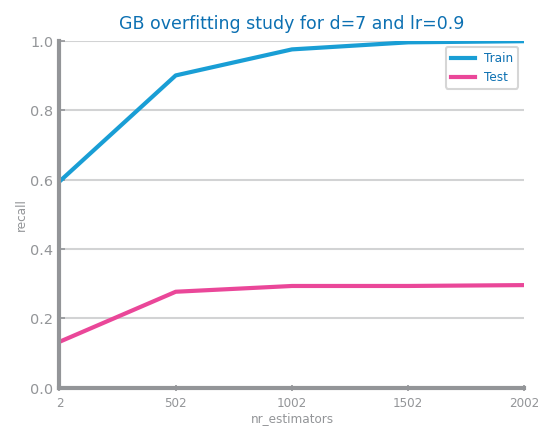

In [20]:
d_max: int = params["params"][0]
lr: float = params["params"][1]
nr_estimators: list[int] = [i for i in range(2, 2501, 500)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric: str = "recall"

for n in nr_estimators:
    clf = GradientBoostingClassifier(n_estimators=n, max_depth=d_max, learning_rate=lr)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    nr_estimators,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"GB overfitting study for d={d_max} and lr={lr}",
    xlabel="nr_estimators",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}/data_classification/gradient_boosting/{eval_metric}_overfitting.png")